# Neural Style Transfer

Neural style transfer consists of applying the style of a reference image to a target image while conserving the content of the target image.

![capture](https://user-images.githubusercontent.com/13174586/51967686-fde6d000-2495-11e9-878c-f675bacb01c1.JPG)

In this context, style essentially means textures, colors, and visual patterns in the image, at various spatial scales; and the content is the higher-level macrostructure of the image. For instance, blue-and-yellow circular brushstrokes are considered to be the style in using *Starry Night by Vincent Van Gogh*, and the buildings in the *Tübingen* photograph are considered to be the content.

The idea of style transfer, which is tightly related to that of texture generation, has had a long history in the image processing community prior to the development of neural style transfer in 2015. But as it turns out, the deep-learning-based implementations of style transfer offer results unparalleled by what had been previously achieved with classical computer-vision techniques, and they triggered an amazing renaissance in creative applications of computer vision.

The key notion behind implementing style transfer is the same idea that’s central to all deep-learning algorithms: we define a loss function to specify what we want to achieve, and we minimize this loss. We know what we want to achieve: conserving
the content of the original image while adopting the style of the reference image. If we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following:

`loss = distance(style(reference_image) - style(generated_image)) +
distance(content(original_image) - content(generated_image))`

Here, `distance` is a norm function such as the `L2` norm, content is a function that takes an image and computes a representation of its content, and style is a function that takes an image and computes a representation of its style. Minimizing this loss causes `style(generated_image)` to be close to `style(reference_image)`, and `content(generated_image)` is close to `content(generated_image)`, thus achieving style transfer as we defined it.

A fundamental observation made by Gatys et al. was that deep convolutional neural networks offer a way to mathematically define the `style` and `content` functions.

Let’s see how.

### The Content Loss

As we already know, activations from earlier layers in a network contain local information about the image, whereas activations from higher layers contain increasingly global, abstract information. Formulated in a different way, the activations of the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore, we’d expect the content of an image, which is more global and abstract, to be captured by the representations of the upper layers in a convnet.

A good candidate for content loss is thus the L2 norm between the activations of an upper layer in a pretrained convnet, computed over the target image, and the activations of the same layer computed over the generated image. This guarantees that, as seen from the upper layer, the generated image will look similar to the original target image. Assuming that what the upper layers of a convnet see is really the content of their input images, then this works as a way to preserve image content.

### The Style Loss

The content loss only uses a single upper layer, but the style loss as defined by Gatys et al. uses multiple layers of a convnet: you try to capture the appearance of the stylereference image at all spatial scales extracted by the convnet, not just a single scale. For the style loss, Gatys et al. use the Gram matrix of a layer’s activations: the inner product of the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the layer’s features. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically
correspond to the appearance of the textures found at this scale.

Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across the style-reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales look similar across the style-reference image and the generated image.

In short, we can use a pretrained convnet to define a loss that will do the following:
 - Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The convnet should “see” both the target image and the generated image as containing the same things.
 - Preserve style by maintaining similar correlations within activations for both low level layers and high-level layers. Feature correlations capture textures : the generated image and the style-reference image should share the same textures at different spatial scales.

Now, let’s look at a Keras implementation of the original 2015 neural style transfer algorithm.

### Neural Style Transfer in Keras

Neural style transfer can be implemented using any pretrained convnet. Here, we’ll use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16 network introduced in chapter 5, with three more convolutional layers.

This is the general process:
 - Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
 - Use the layer activations computed over these three images to define the loss function described earlier, which we’ll minimize in order to achieve style transfer.
 - Set up a gradient-descent process to minimize this loss function.

Let’s start by defining the paths to the style-reference image and the target image. To make sure that the processed images are a similar size (widely different sizes make style transfer more difficult), we’ll later resize them all to a shared height of 400 px.

### Define Initial Variables

In [63]:
from keras.preprocessing.image import load_img, img_to_array

target_image_path= 'Style_Transfer\\scenery2.jpg' #Path to the image we want to transform
style_reference_image_path= 'Style_Transfer\\tripsy2.jpg' #Path to the style image

width, height= load_img(target_image_path).size     #Dimensions of the
img_height= 400
img_width= int(width*img_height/height)             #generated picture

We need some auxiliary functions for loading, preprocessing, and postprocessing the images that go in and out of the VGG19 convnet.

### Auxiliary Functions

In [64]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img= load_img(image_path, target_size=(img_height, img_width))
    img= img_to_array(img)
    img= np.expand_dims(img, axis=0)
    img= vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:,:,0] += 103.939                 #Zero-centering by removing the mean pixel value
    x[:,:,1] += 116.779                 #from ImageNet. This reverses a transformation
    x[:,:,2] += 123.68                  #done by vgg19.preprocess_input
    x= x[:,:,::-1]           #Converts images from 'BGR' to 'RGB'. This is also part of the reversal of vgg19.preprocess_input.
    x= np.clip(x, 0, 255).astype('uint8')
    return x

Let’s set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder that will contain the generated image. A placeholder is a symbolic tensor, the values of which are provided externally via Numpy arrays. The style-reference and target image are static and thus defined using `K.constant`, whereas the values contained in the placeholder of the generated image will change over time.

### Load The Pretrained VGG19 Network and Apply it to The Three Images

In [65]:
from keras import backend as K

target_image= K.constant(preprocess_image(target_image_path))
style_reference_image= K.constant(preprocess_image(style_reference_image_path))
combination_image= K.placeholder((1,img_height, img_width,3))   #Placeholder that will contain the generated image

In [66]:
input_tensor= K.concatenate([target_image, style_reference_image, combination_image], axis=0) #Combines the three
                                                                                               #images in a single batch

In [67]:
print('Loading Model...')
model= vgg19.VGG19(input_tensor= input_tensor,                      #Builds the VGG19 network with
                   weights='imagenet',                              #the batch of three images as input. The model will be
                   include_top= False)                              #loaded with pretrained ImageNet weights.#

model.summary()
print('...Model Loaded')

Loading Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Let’s define the content loss, which will make sure the top layer of the VGG19 convnet has a similar view of the target image and the generated image.

### Content Loss

In [68]:
def content_loss(base, combination):
    return K.sum(K.square(combination-base))

Next is the style loss. It uses an auxiliary function to compute the Gram matrix of an input matrix: a map of the correlations found in the original feature matrix.

### Style Loss

In [69]:
def gram_matrix(x):
    features= K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gram= K.dot(features, K.transpose(features))
    return gram

In [70]:
def style_loss(style, combination):
    s= gram_matrix(style)
    c= gram_matrix(combination)
    channels= 3
    size=img_height*img_width
    return K.sum(K.square(s-c))/(4.0*(channels**2)*(size**2))

To these two loss components, we add a third: the total variation loss, which operates on the pixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.

### Total Variation Loss

In [71]:
def total_variation_loss(x):
    a= K.square(x[:, :img_height-1, :img_width-1, :]-
                x[:,1:, :img_width-1, :])
    b= K.square(x[:, :img_height-1, :img_width-1, :]-
               x[:,:img_height-1, 1:, :])
    return K.sum(K.pow(a+b, 1.25))

The loss that we minimize is a weighted average of these three losses. To compute the content loss, wew use only one upper layer—the `block5_conv2` layer—whereas for the style loss, we use a list of layers than spans both low-level and high-level layers. We add the total variation loss at the end.

Depending on the style-reference image and content image we’re using, we’ll likely want to tune the content_weight coefficient (the contribution of the content loss to the total loss). A higher `content_weight` means the target content will be more
recognizable in the generated image.

### Define The Final Loss That We’ll Minimize

In [72]:
outputs_dict= dict([(layer.name, layer.output) for layer in model.layers]) #Dictionary that maps layer names to activation tensors
content_layer= 'block5_conv2'  #Layer used for content loss
style_layers= ['block1_conv1', 
              'block2_conv1',  #Layers used for style loss
              'block3_conv1',
              'block4_conv1',
              'block5_conv1']

total_variation_weight= 1e-4  #Weights in the weighted average
style_weight=1                #of the loss components
content_weight= 0.025  

In [73]:
#Adds the content loss
loss= K.variable(0.0)                  #We’ll define the loss by adding all components to this scalar variable.
layer_features= outputs_dict[content_layer] 
target_image_features= layer_features[0, :, :, :]
combination_features= layer_features[2, :, :, :]
loss += content_weight*content_loss(target_image_features, combination_features)

In [74]:
for layer_name in style_layers:                      #Adds a style loss component for each target layer
    layer_features =outputs_dict[layer_name]
    style_reference_features= layer_features[1, :, :, :]
    combination_features= layer_features[2, :, :, :]
    sl= style_loss(style_reference_features, combination_features)
    loss +=(style_weight/ len(style_layers))*sl

In [75]:
#Adds the total variation loss

loss += total_variation_weight*total_variation_loss(combination_image)

Finally, we’ll set up the gradient-descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, so that’s what we’ll use here.

The L-BFGS algorithm comes packaged with SciPy, but there are two slight limitations with the SciPy implementation:
 - It requires that us pass the value of the loss function and the value of the gradients as two separate functions.
 - It can only be applied to flat vectors, whereas we have a 3D image array.
It would be inefficient to compute the value of the loss function and the value of the gradients independently, because doing so would lead to a lot of redundant computation between the two; the process would be almost twice as slow as computing them
jointly. To bypass this, we’ll set up a Python class named Evaluator that computes both the loss value and the gradients value at once, returns the loss value when called the first time, and caches the gradients for the next call.

### Set Up The Gradient-Descent Process

In [76]:
grads= K.gradients(loss, combination_image)[0] #Gets the gradients of the generated image with regard to the loss

fetch_loss_and_grads= K.function([combination_image], [loss, grads]) #Function to fetch the values of the 
                                                                    #current loss and the current gradients

class Evaluator(object):              #This class wraps fetch_loss_and_grads
    def __init__(self):               #in a way that lets us retrieve the losses and
        self.loss_value= None         #gradients via two separate method calls, which is
        self.grads_values= None       #required by the SciPy optimizer we'll use
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator=Evaluator()

Finally, we can run the gradient-ascent process using SciPy’s L-BFGS algorithm, saving the current generated image at each iteration of the algorithm (here, a single iteration represents 20 steps of gradient ascent).

### Style-Transfer Loop

In [77]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix='NST'
iterations= 20

x= preprocess_image(target_image_path) #This is the initial state: the target image
x= x.flatten()                     #We flatten the image because scipy.optimize.fmin_l_bfgs_b can only process flat vectors.
for i in range(iterations):
    print('Start of Iteration ', i)
    start_time=time.time()
    x, min_val, info= fmin_l_bfgs_b(evaluator.loss,          #Runs L-BFGS optimization over the pixels of the generated image to
                                    x,                       #minimize the neural style loss. Note that we have 
                                    fprime=evaluator.grads,  #to pass the function that computes the loss and the
                                    maxfun=20)               #function that computes the gradients as two separate arguments
    print('Current Loss Value', min_val)
    img=x.copy().reshape((img_height, img_width, 3))
    img= deprocess_image(img)
    fname=result_prefix+'_at_iteration_%d.png'%i
    imsave(fname, img)
    print('Image saved as: ', fname)
    end_time= time.time()
    print("Iteration %d completed in %ds" % (i, end_time-start_time))


Start of Iteration  0
Current Loss Value 9538864000.0
Image saved as:  NST_at_iteration_0.png
Iteration 0 completed in 23s
Start of Iteration  1


c:\users\soumyama\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current Loss Value 4127971600.0
Image saved as:  NST_at_iteration_1.png
Iteration 1 completed in 21s
Start of Iteration  2
Current Loss Value 2311582000.0
Image saved as:  NST_at_iteration_2.png
Iteration 2 completed in 22s
Start of Iteration  3
Current Loss Value 1634107900.0
Image saved as:  NST_at_iteration_3.png
Iteration 3 completed in 21s
Start of Iteration  4
Current Loss Value 1207411100.0
Image saved as:  NST_at_iteration_4.png
Iteration 4 completed in 23s
Start of Iteration  5
Current Loss Value 987382900.0
Image saved as:  NST_at_iteration_5.png
Iteration 5 completed in 22s
Start of Iteration  6
Current Loss Value 814425600.0
Image saved as:  NST_at_iteration_6.png
Iteration 6 completed in 22s
Start of Iteration  7
Current Loss Value 718881000.0
Image saved as:  NST_at_iteration_7.png
Iteration 7 completed in 22s
Start of Iteration  8
Current Loss Value 633458940.0
Image saved as:  NST_at_iteration_8.png
Iteration 8 completed in 22s
Start of Iteration  9
Current Loss Value 5

<Figure size 432x288 with 0 Axes>

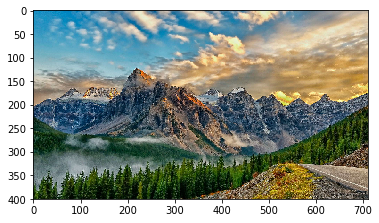

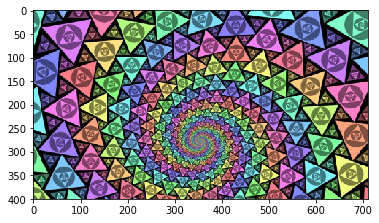

<Figure size 432x288 with 0 Axes>

In [78]:
from matplotlib import pyplot as plt
%matplotlib inline

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()